## Imports

In [2]:
!pip install pymoo

In [3]:
# IMPORTS
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import random
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.selection.tournament import TournamentSelection
from pymoo.termination.default import DefaultMultiObjectiveTermination
from tensorflow.keras.models import clone_model
from pymoo.core.problem import Problem
from keras.utils import to_categorical


## Classes

In [4]:
# CLASSES

class Server:
    def __init__(self, devices_list):
        self.model = Server.create_model()
        self.current_learning_iteration = 0
        self.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES = []
        self.x_test_global = []
        self.y_test_global = []
        self.devices = devices_list

    # def evaluate(self, verbose = 1):
    #     test_loss, test_acc = self.model.evaluate(self.x_test_global, self.y_test_global, verbose)
    #     return test_loss, test_acc

    def evaluate(self, x_test=None, y_test=None, verbose = 1):
        if x_test is None and y_test is None:
            test_loss, test_acc = self.model.evaluate(self.x_test_global, self.y_test_global, verbose)
            return test_loss, test_acc
        test_loss, test_acc = self.model.evaluate(x_test, y_test, verbose=verbose)
        return test_loss, test_acc

    def get_weights(self):
        return self.model.get_weights()

    def set_aggregated_weight(self):
        self.model.set_weight(Server.aggregate_weights())

    def give_global_model_weights_to_bitstring_devices(self, bitstring):
        for device in self.devices:
            if int(bitstring[int(device.id)]) == 1:
                device.model.set_weights(self.model.get_weights())

    def create_model():
        model = keras.Sequential([
            layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])
        model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
                        # new
                        loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def aggregate_weights(self, bitstring):
        """Computes the weighted average of model weights from all devices and updates the global model."""
        def sum_all_nested_lists(list_of_lists):
            def recursive_sum(lists):
                if isinstance(lists[0], list):
                    return [recursive_sum([lst[i] for lst in lists]) for i in range(len(lists[0]))]
                else:
                    return sum(lists)

            return recursive_sum(list_of_lists)

        def multiply_nested_list(lst, factor):
            result = []
            for item in lst:
                if isinstance(item, list):
                    # Recursively handle sublists
                    result.append(multiply_nested_list(item, factor))
                else:
                    # Multiply number
                    result.append(item * factor)
            return result

        selected_devices = []
        for device in self.devices:
            if int(bitstring[int(device.id)]) == 1:
                selected_devices.append(device)

        num_devices = len(selected_devices)
        if num_devices == 0:
            print("No devices available for aggregation.")
            return

        device_participation_ratio = []
        data_lengths = []

        for device in selected_devices:
            print("*******************")
            print(device.id)
            device_participation_ratio.append(device.last_round_participated / self.current_learning_iteration)
            # print("this device's participation ratio:")
            # print(device.last_round_participated / self.current_learning_iteration)
            data_lengths.append(len(device.data[0]))
            # print("this device's data to all ratio:")
            # print(len(device.data[0])/60000.0)

        sum_data = 0
        for data_len in data_lengths:
            sum_data += data_len

        data_fractions = []
        for device in selected_devices:
            data_fractions.append(len(device.data[0])/float(sum_data))



        # new
        combined_weights = [fraction * ratio for fraction, ratio in zip(data_fractions, device_participation_ratio)]
        total_weight = sum(combined_weights)
        normalized_weights = [w / total_weight for w in combined_weights]
        print(normalized_weights)


        aggregated_weights_devices = []
        for d in range(len(selected_devices)):
            # aggregated_weights_devices.append(multiply_nested_list(selected_devices[d].model.get_weights(), data_fractions[d]*device_participation_ratio[d]))
            aggregated_weights_devices.append(multiply_nested_list(self.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES[int(selected_devices[d].id)], normalized_weights[d]))

        aggregated_weights = sum_all_nested_lists(aggregated_weights_devices)
        # TODO: Weighted multiplication for each node in each layer of the neural network of the received devices and then summing
        #       the related parts together so that we get a full weighted average of all these devices' models

        print("Aggregated weights:")
        for layer_idx, layer_weights in enumerate(aggregated_weights):
            print(f"Layer {layer_idx}: {layer_weights.shape}")
            
        
        return aggregated_weights


class Device:
    def __init__(self, id, ram, storage, cpu, bandwidth, battery, charging):
        self.id = id
        self.ram = ram
        self.storage = storage
        self.cpu = cpu
        self.bandwidth = bandwidth
        self.battery = battery
        self.charging = charging
        self.model = Server.create_model()
        self.last_round_participated = 0
        self.data = None  # Placeholder for dataset partition
        self.test_data = None
        self.number_of_times_fitted = 0
        
    def lose_battery(self):
        if float(self.battery) > 0.3:
            self.battery -= 0.3
        else:
            self.battery = 0
        


class FederatedLearningProblem(Problem):
    def __init__(self, devices, server: Server):
        super().__init__(
            n_var=len(devices),         # Number of variables (bitstring length)
            n_obj=3,                   # Number of objectives
            n_constr=0,                # No constraints
            xl=np.zeros(len(devices)),  # Lower bound (0)
            xu=np.ones(len(devices)),   # Upper bound (1)
            type_var=np.bool_          # Binary variables (bitstrings)
        )
        self.devices = devices
        self.server = server
        self.x_test_global = server.x_test_global
        self.y_test_global = server.y_test_global

        # Save the initial global model weights
        self.initial_global_weights = server.get_weights()

    def _evaluate(self, X, out, *args, **kwargs):
        """Evaluates objective values for each solution in the population."""
        num_solutions = len(X)
        F = np.zeros((num_solutions, 3))  # Initialize objective matrix

        for i, bitstring in enumerate(X):
            # print(f"evaluating: {bitstring}")
            # TODO: check bitstring type
            # Reset the global model to its initial state
            # Update device participation based on the bitstring
            selected_devices = [device for device, bit in zip(self.devices, bitstring) if int(bit) == 1]

            # Objective 1: Hardware Objectives (maximize)
            hardware_score = 0.0
            for device in selected_devices:
                device_hardware_score = float(6 - (device.ram + device.storage + device.cpu + device.bandwidth + device.battery + device.charging)) / 6.0
                hardware_score += device_hardware_score

            F[i, 0] = hardware_score/len(selected_devices)  # Minimize (negative of hardware score)

            fairness_score = 0
            for device in self.devices:
                if bitstring[int(device.id)] == 1:
                    # new
                    _, accuracy = self.server.evaluate(device.test_data[0], device.test_data[1], verbose=0)
                    fairness_score += accuracy

            F[i, 1] = fairness_score/float(len(selected_devices))  # Minimize (negative of fairness score)  # Added (/Selected Devices) to normalize between 0 and 1

            # Objective 3: Global Model Accuracy (Performance) (maximize)
            temp_global_model = Server.create_model()
            temp_global_model.set_weights(self.performance_objective_aggregation(selected_devices))
            _, global_accuracy = temp_global_model.evaluate(self.server.x_test_global, self.server.y_test_global, verbose=0)
            F[i, 2] = 1 - global_accuracy  # Minimize (1 - accuracy)

        out["F"] = F  # Set the objective values

    def performance_objective_aggregation(self, selected_devices):

        def sum_all_nested_lists(list_of_lists):
            def recursive_sum(lists):
                if isinstance(lists[0], list):
                    return [recursive_sum([lst[i] for lst in lists]) for i in range(len(lists[0]))]
                else:
                    return sum(lists)

            return recursive_sum(list_of_lists)

        def multiply_nested_list(lst, factor):
            result = []
            for item in lst:
                if isinstance(item, list):
                    # Recursively handle sublists
                    result.append(multiply_nested_list(item, factor))
                else:
                    # Multiply number
                    result.append(item * factor)
            return result

        num_devices = len(selected_devices)
        if num_devices == 0:
            print("No devices available for aggregation.")
            return

        device_weights_all_layers = []
        device_participation_ratio = []
        # device_participation_weights = []
        data_lengths = []

        for device in selected_devices:
            device_weights_all_layers.append(self.server.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES[int(device.id)])
            # print("*******************")
            # print(device.id)
            device_participation_ratio.append(device.last_round_participated / self.server.current_learning_iteration)
            # device_participation_weights.append(device.last_round_participated)
            # print("this device's participation ratio:")
            # print(device.last_round_participated / self.server.current_learning_iteration)

            data_lengths.append(len(device.data[0]))
            # print("this device's data to all ratio:")
            # print(len(device.data[0])/60000.0)

        sum_data = 0
        for data_len in data_lengths:
            sum_data += data_len

        # data_weights = []
        data_fractions = []
        for device in selected_devices:
            data_fractions.append(len(device.data[0])/float(sum_data))
            # data_weights.append(len(device.data[0]))


        # new:
        # weights = []
        combined_weights = [fraction * ratio for fraction, ratio in zip(data_fractions, device_participation_ratio)]
        total_weight = sum(combined_weights)
        normalized_weights = [w / total_weight for w in combined_weights]
        print(normalized_weights)


        aggregated_weights_devices = []
        for d in range(len(selected_devices)):
            # aggregated_weights_devices.append(multiply_nested_list(self.server.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES[int(selected_devices[d].id)], data_fractions[d]*device_participation_ratio[d]))
            aggregated_weights_devices.append(multiply_nested_list(self.server.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES[int(selected_devices[d].id)], normalized_weights[d]))


        aggregated_weights = sum_all_nested_lists(aggregated_weights_devices)

        # print("Aggregated weights:")
        # for layer_idx, layer_weights in enumerate(aggregated_weights):
        #     print(f"Layer {layer_idx}: {layer_weights.shape}")
        return aggregated_weights




## Functions

In [5]:
# Functions

def fit_bitstring_devices(bitstring, server: Server, epochs=7):
    '''
    server: for using its "current_learning_iteration" variable
    '''

    server.current_learning_iteration += 1
    for device in server.devices:
        if bitstring[int(device.id)] == 1:
            # new
            device.lose_battery()
            
            device.model.fit(device.data[0], device.data[1], epochs=epochs, verbose=1)
            print(device.id)
            device.last_round_participated = server.current_learning_iteration
            server.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES[int(device.id)] = device.model.get_weights()
            device.number_of_times_fitted += 1



## Load Data

### Load Devices

In [6]:
# Load dataset from CSV
csv_file = 'devices.csv'
df = pd.read_csv(csv_file)
df.columns = df.columns.str.strip().str.lower()

# Convert CSV rows into device objects
devices = []

for _, row in df.iterrows():
    device = Device(
        row['id'], row['ram'], row['storage'], row['cpu'], row['bandwidth'], row['battery'],
        row.get('charging', 0)
    )
    devices.append(device)


# LIMIT TO 30 DEVICES
devices = devices[:30]

d:\Github Repos\FL\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Object Initializations

In [7]:
# Global Model
server = Server(devices_list=devices)
server.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES = [None for _ in range(len(devices))]

### Split Data Among Devices

In [8]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Convert labels to categorical (one-hot encoded)
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Normalize data and reshape for CNN
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)  # Add channel dimension

x_test = x_test.astype("float32") / 255.0
x_test = np.expand_dims(x_test, -1)  # Add channel dimension

# Shuffle data
# indices = np.arange(len(x_train))
# np.random.shuffle(indices)
# x_train, y_train = x_train[indices], y_train[indices]




# new
# Lower the amount of data for devices
x_train = x_train[:int(len(x_train)/8)]
y_train = y_train[:int(len(y_train)/8)]




# Correct test split
split_index = int(0.8 * len(x_test))
x_test_devices, y_test_devices = x_test[:split_index], y_test[:split_index]
server.x_test_global, server.y_test_global = x_test[split_index:], y_test[split_index:]

# Training data (for devices)
x_train_devices, y_train_devices = x_train, y_train

# Split training data among devices
num_devices = len(devices)
split_size = len(x_train_devices) // num_devices

for i, device in enumerate(devices):
    start = i * split_size
    end = (i + 1) * split_size if i < num_devices - 1 else len(x_train_devices)
    device.data = (x_train_devices[start:end], y_train_devices[start:end])

# Split test data (device-level)
split_size = len(x_test_devices) // num_devices

for i, device in enumerate(devices):
    start = i * split_size
    end = (i + 1) * split_size if i < num_devices - 1 else len(x_test_devices)
    device.test_data = (x_test_devices[start:end], y_test_devices[start:end])

### Load Other Data

## First Iteration

In [9]:
# First Iteration
bitstring = [1 for _ in range(len(devices))]
print(bitstring)

# global model sends its weights to all devices
server.give_global_model_weights_to_bitstring_devices(bitstring)

test_loss, test_acc = server.evaluate(verbose=0)
print(f"Global Model Accuracy: {test_acc:.4f}")
print("------------------------------------------------------------")
fit_bitstring_devices(bitstring, server)
server.model.set_weights(server.aggregate_weights(bitstring))
print("------------------------------------------------------------")
test_loss, test_acc = server.evaluate(verbose=0)
print(f"Global Model Accuracy: {test_acc:.4f}")

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1294 - loss: 2.3186 
Global Model Accuracy: 0.1230
------------------------------------------------------------
Epoch 1/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1356 - loss: 2.3001  
Epoch 2/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2152 - loss: 2.2619 
Epoch 3/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3394 - loss: 2.2090 
Epoch 4/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4639 - loss: 2.1615 
Epoch 5/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4652 - loss: 2.1180 
Epoch 6/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5089 - loss: 2.0699 
Epoch 7/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5642 - loss: 2.0004 
0.0
Epoch 1/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1706 - loss: 2.3061  
Epoch 2/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2176 - loss: 2.2583 


In [10]:
!pip install pymoo

## NSGA2 Loop

In [ ]:
# Parameters
POPULATION_SIZE = 10 # should be 50
NUM_GENERATIONS = 5
NUM_ROUNDS = 1

In [12]:
# Object Initializations

problem = FederatedLearningProblem(
    devices=devices,
    server=server
)


# Step 2: Configure NSGA-II Algorithm
algorithm = NSGA2(
    pop_size=POPULATION_SIZE,
    sampling=BinaryRandomSampling(),      # Random bitstrings
    crossover=TwoPointCrossover(),        # Two-point crossover
    mutation=BitflipMutation(),           # Bit flip mutation
    eliminate_duplicates=True             # Avoid duplicate solutions
)


In [13]:
# DEBUG:
print(server.x_test_global.shape)
print(server.y_test_global.shape)

print(x_train.shape)
print(y_train.shape)

(2000, 28, 28, 1)
(2000, 10)
(7500, 28, 28, 1)
(7500, 10)


In [14]:
from pymoo.core.callback import Callback
import numpy as np

class ParetoLogger(Callback):
    def __init__(self):
        super().__init__()
        self.data["pareto_fronts"] = []     # Objective values F
        self.data["pareto_solutions"] = []  # Decision variables X

    def notify(self, algorithm):
        opt = algorithm.opt
        gen = algorithm.n_gen
        if opt is not None:
            F = opt.get("F")
            X = opt.get("X")
            print(f"Generation {gen}: {len(X)} solutions in opt")  # ← Check this!
            self.data["pareto_fronts"].append(F.copy())
            self.data["pareto_solutions"].append(X.copy())



In [15]:
all_runs_fronts = []  # Stores results across runs
all_runs_solutions = []

for i in range(NUM_ROUNDS):
    # Step 3: Run Optimization
    print("GLOBAL MODEL BEFORE OPTIMIZATION")
    print(server.evaluate())

    callback = ParetoLogger()
    res = minimize(
        problem=problem,
        algorithm=algorithm,
        termination=DefaultMultiObjectiveTermination(n_max_gen=NUM_GENERATIONS),
        # seed=42,
        verbose=True,
        callback=callback
    )
    print("GLOBAL MODEL AFTER OPTIMIZATION")
    print(server.evaluate())


    # Step 4: Extract the Best Pareto Front
    pareto_front = res.F   # Objective values of solutions in Pareto front
    pareto_solutions = res.X  # Corresponding bitstrings

    # Print the Best Pareto Front Solutions
    print("Best Pareto Front (Bitstrings):")
    for bitstring in pareto_solutions:
        print("".join(map(str, bitstring)).replace('True','1').replace('False','0'))

    bitstring = pareto_solutions[0] # for now!
    bitstring = str(bitstring).replace('False','0').replace('True','1')
    for char in bitstring:
        if char != '0' and char != '1':
            bitstring = bitstring.replace(char,'')

    print(len(bitstring))
    print(bitstring)
    temp_bitstring = []
    for bit in bitstring:
        temp_bitstring.append(bit)
    bitstring = temp_bitstring

    a = server.model.get_weights()
    test_loss, test_acc = server.evaluate()
    print(f"Global Model Accuracy: {test_acc:.4f}")
    print("------------------------------------------------------------")
    print(server.current_learning_iteration, " 1")
    server.give_global_model_weights_to_bitstring_devices(bitstring)
    print(server.current_learning_iteration, " 2")
    fit_bitstring_devices(bitstring, server=server, epochs=15)
    print(server.current_learning_iteration, " 3")
    server.model.set_weights(server.aggregate_weights(bitstring))
    print(server.current_learning_iteration, " 4")
    print("------------------------------------------------------------")
    test_loss, test_acc = server.evaluate()
    print(f"Global Model Accuracy: {test_acc:.4f}")
    # b = server.model.get_weights()
    # for i in range(len(b)):
    #     print(a[i])
    #     print("----------")
    #     print(b[i])

    # Save the pareto fronts from this run
    all_runs_fronts.append(callback.data["pareto_fronts"])
    all_runs_solutions.append(callback.data["pareto_solutions"])


GLOBAL MODEL BEFORE OPTIMIZATION
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6108 - loss: 2.0050
(2.0185043811798096, 0.5879999995231628)
[0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667]
[0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667]
[0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.0666

In [16]:
print(len(all_runs_fronts))
print(len(all_runs_solutions))

print(len(all_runs_fronts[0][0]))
print(all_runs_fronts[0][0])

1
1
9
[[0.53915612 0.53576248 0.41850001]
 [0.52823725 0.51002506 0.44050002]
 [0.50989086 0.52180451 0.43800002]
 [0.50433406 0.54385964 0.38599998]
 [0.52656006 0.52447414 0.42449999]
 [0.51601873 0.54202814 0.39600003]
 [0.53608623 0.54039685 0.39249998]
 [0.54855585 0.5        0.44400001]
 [0.53876677 0.52410437 0.4285    ]]


In [17]:
# x = objective 1
# y = objective 2
# z = objective 3

def get_min_objective_value(run_index: int, generation_index: int, objective_index: int, verbose: int=0):
    temp_list = []
    for solution_objective_values in all_runs_fronts[run_index][generation_index]:
        temp_list.append(solution_objective_values[objective_index])
    if verbose == 1:
        print(f"For the run index {run_index} and generation index {generation_index}:")
        print(f"MIN of objective index {objective_index}: {min(temp_list)}")
    return min(temp_list)

def get_max_objective_value(run_index: int, generation_index: int, objective_index: int, verbose: int=0):
    temp_list = []
    for solution_objective_values in all_runs_fronts[run_index][generation_index]:
        temp_list.append(solution_objective_values[objective_index])
    if verbose == 1:
        print(f"For the run index {run_index} and generation index {generation_index}:")
        print(f"MAX of objective index {objective_index}: {max(temp_list)}")
    return max(temp_list)

In [ ]:
def save_run_gen_to_file(run_index: int, gen_index: int):
    output = ""
    for solution_index in range(len(all_runs_solutions[run_index][gen_index])):
        print(f"solution: {str(all_runs_solutions[run_index][gen_index][solution_index]).replace("True", "1").replace("False", "0").replace("  ", " ").replace(" ",",").replace("\n","")}")
        output += f"solution: {str(all_runs_solutions[run_index][gen_index][solution_index]).replace("True", "1").replace("False", "0").replace("  ", " ").replace(" ",",").replace("\n","")}\n"

        print(f"obj1: {all_runs_fronts[run_index][gen_index][solution_index][0]}")
        output += f"obj1: {all_runs_fronts[run_index][gen_index][solution_index][0]}\n"
        
        print(f"obj2: {all_runs_fronts[run_index][gen_index][solution_index][1]}")
        output += f"obj2: {all_runs_fronts[run_index][gen_index][solution_index][1]}\n"
        
        print(f"obj3: {all_runs_fronts[run_index][gen_index][solution_index][2]}")
        output += f"obj3: {all_runs_fronts[run_index][gen_index][solution_index][2]}\n"
        
        print("--------------")
        output += "--------------\n"

    with open(f"run_{run_index}_gen_{gen_index}.txt", "w") as f:
        f.write(output)
    
    
for run_index in range(len(all_runs_fronts)):
    for gen_index in range(len(run_index)):
        save_run_gen_to_file(run_index=run_index, gen_index=gen_index)

solution: [0,1,1,0,0,1,0,1,1,0,0,0,1,1,1,0,0,1,0,0,0,1,0,1,1,1,0,0,1,1]
obj1: 0.5391561162188123
obj2: 0.535762482881546
obj3: 0.41850000619888306
--------------
solution: [0,1,1,1,0,0,0,1,0,0,1,0,1,1,1,1,1,0,0,1,0,1,1,0,0,0,0,1,1,0]
obj1: 0.5282372512484873
obj2: 0.5100250621636708
obj3: 0.44050002098083496
--------------
solution: [,1,1,0,0,0,1,0,0,0,1,0,0,1,1,1,1,1,0,1,0,0,0,1,1,1,1,0,0,1,0]
obj1: 0.5098908611620552
obj2: 0.5218045055866242
obj3: 0.43800002336502075
--------------
solution: [,1,0,1,1,0,1,1,0,1,0,0,1,0,0,0,1,1,0,1,1,1,1,1,1,1,1,1,0,0,0]
obj1: 0.5043340616010544
obj2: 0.543859644068612
obj3: 0.38599997758865356
--------------
solution: [,1,1,1,0,1,1,0,1,0,0,0,1,1,1,1,0,0,1,1,1,1,0,1,0,1,1,1,0,0,1]
obj1: 0.5265600593144604
obj2: 0.5244741377077604
obj3: 0.4244999885559082
--------------
solution: [0,1,1,0,0,0,0,1,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1,1,1,0,1,1,1]
obj1: 0.5160187252439297
obj2: 0.54202814300855
obj3: 0.3960000276565552
--------------
solution: [0,1,1,1,0,0,0,

011001011000111001000101110011

011100010010111110010110000110

110001000100111110100011110010

101101101001000110111111111000

111011010001111001111010111001

011000011010100100100101110111

011100010000000011110111001001

011101010110100011000010000100

111101110010110001101100100110

1
[[array([[0.53915612, 0.53576248, 0.41850001],
       [0.52823725, 0.51002506, 0.44050002],
       [0.50989086, 0.52180451, 0.43800002],
       [0.50433406, 0.54385964, 0.38599998],
       [0.52656006, 0.52447414, 0.42449999],
       [0.51601873, 0.54202814, 0.39600003],
       [0.53608623, 0.54039685, 0.39249998],
       [0.54855585, 0.5       , 0.44400001],
       [0.53876677, 0.52410437, 0.4285    ]]), array([[0.52823725, 0.51002506, 0.44050002],
       [0.50989086, 0.52180451, 0.43800002],
       [0.52656006, 0.52447414, 0.42449999],
       [0.54855585, 0.5       , 0.44400001],
       [0.52313571, 0.53383458, 0.38999999],
       [0.52207853, 0.51879699, 0.43650001],
       [0.50042411, 0.54024767,

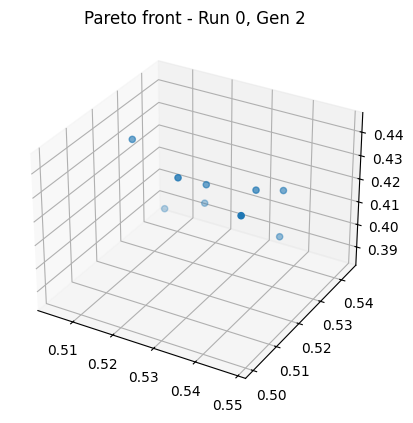

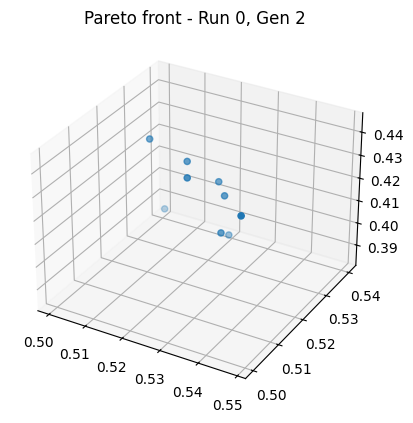

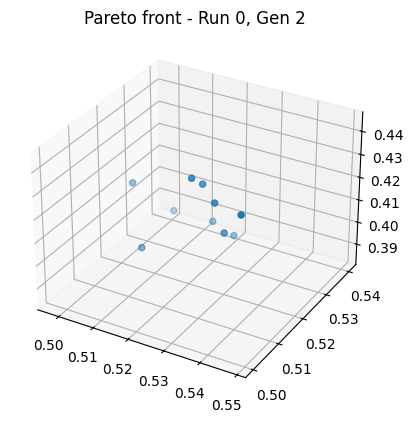

In [ ]:
# import matplotlib.pyplot as plt

# for solution in all_runs_solutions[0][0]:
#     print(str(solution).replace('True','1').replace('False','0').replace(' ','').replace('[','').replace(']','').replace('\n',''))
#     print()
# print(len(all_runs_solutions))
# print(all_runs_fronts)

# Example: visualize the Pareto front from generation 2 of run 0 (if 3 objectives)
# front = all_runs_fronts[0][0]
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(front[:,0], front[:,1], front[:,2])
# ax.set_title("Pareto front - Run 0, Gen 2")
# plt.show()

# front = all_runs_fronts[0][1]
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(front[:,0], front[:,1], front[:,2])
# ax.set_title("Pareto front - Run 0, Gen 2")
# plt.show()

# front = all_runs_fronts[0][2]
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(front[:,0], front[:,1], front[:,2])
# ax.set_title("Pareto front - Run 0, Gen 2")
# plt.show()

In [ ]:
import plotly.graph_objects as go

# Choose a generation and run
# gen_idx = 0
# run_idx = 0

for run_idx in range(len(all_runs_fronts)):
    for gen_idx in range(len(all_runs_fronts[run_idx])):
        
        front = all_runs_fronts[run_idx][gen_idx]

        fig = go.Figure(data=[go.Scatter3d(
            x=front[:, 0],
            y=front[:, 1],
            z=front[:, 2],
            mode='markers',
            marker=dict(
                size=5,
                color=front[:, 2],  # Color by third objective
                colorscale='Viridis',
                opacity=0.8
            )
        )])

        min_x = get_min_objective_value(run_idx, gen_idx, 0, 1)
        max_x = get_max_objective_value(run_idx, gen_idx, 0, 1)
        min_y = get_min_objective_value(run_idx, gen_idx, 1, 1)
        max_y = get_max_objective_value(run_idx, gen_idx, 1, 1)
        min_z = get_min_objective_value(run_idx, gen_idx, 2, 1)
        max_z = get_max_objective_value(run_idx, gen_idx, 2, 1)
        
        fig.update_layout(
            title=f"Pareto Front - Run {run_idx}, Gen {gen_idx}",
            scene=dict(
                xaxis=dict(title="Objective 1", range=[min_x, max_x]),
                yaxis=dict(title="Objective 2", range=[min_y, max_y]),
                zaxis=dict(title="Objective 3", range=[min_z, max_z])
            )
        )

        fig.show()


For the run index 0 and generation index 0:
MIN of objective index 0: 0.5043340616010544
For the run index 0 and generation index 0:
MAX of objective index 0: 0.5485558510945809
For the run index 0 and generation index 0:
MIN of objective index 1: 0.5
For the run index 0 and generation index 0:
MAX of objective index 1: 0.543859644068612
For the run index 0 and generation index 0:
MIN of objective index 2: 0.38599997758865356
For the run index 0 and generation index 0:
MAX of objective index 2: 0.4440000057220459


For the run index 0 and generation index 1:
MIN of objective index 0: 0.5004241067779986
For the run index 0 and generation index 1:
MAX of objective index 0: 0.5485558510945809
For the run index 0 and generation index 1:
MIN of objective index 1: 0.5
For the run index 0 and generation index 1:
MAX of objective index 1: 0.5402476717444027
For the run index 0 and generation index 1:
MIN of objective index 2: 0.38499999046325684
For the run index 0 and generation index 1:
MAX of objective index 2: 0.4440000057220459


For the run index 0 and generation index 2:
MIN of objective index 0: 0.49758062186140084
For the run index 0 and generation index 2:
MAX of objective index 0: 0.5485558510945809
For the run index 0 and generation index 2:
MIN of objective index 1: 0.5
For the run index 0 and generation index 2:
MAX of objective index 1: 0.5402476717444027
For the run index 0 and generation index 2:
MIN of objective index 2: 0.38499999046325684
For the run index 0 and generation index 2:
MAX of objective index 2: 0.4440000057220459


For the run index 0 and generation index 3:
MIN of objective index 0: 0.49531113764518314
For the run index 0 and generation index 3:
MAX of objective index 0: 0.5562149596435442
For the run index 0 and generation index 3:
MIN of objective index 1: 0.4999999970197678
For the run index 0 and generation index 3:
MAX of objective index 1: 0.5402476717444027
For the run index 0 and generation index 3:
MIN of objective index 2: 0.38499999046325684
For the run index 0 and generation index 3:
MAX of objective index 2: 0.4480000138282776


For the run index 0 and generation index 4:
MIN of objective index 0: 0.49531113764518314
For the run index 0 and generation index 4:
MAX of objective index 0: 0.5485558510945809
For the run index 0 and generation index 4:
MIN of objective index 1: 0.49624059958891437
For the run index 0 and generation index 4:
MAX of objective index 1: 0.5418233014643192
For the run index 0 and generation index 4:
MIN of objective index 2: 0.3774999976158142
For the run index 0 and generation index 4:
MAX of objective index 2: 0.45649999380111694


In [21]:
# Step 4: Extract the Best Pareto Front
pareto_front = res.F   # Objective values of solutions in Pareto front
pareto_solutions = res.X  # Corresponding bitstrings

# Print the Best Pareto Front Solutions
print("Best Pareto Front (Bitstrings):")
for bitstring in pareto_solutions:
    print("".join(map(str, bitstring)).replace('True','1').replace('False','0'))

bitstring = pareto_solutions[0] # for now!
bitstring = str(bitstring).replace('False','0').replace('True','1')
for char in bitstring:
    if char != '0' and char != '1':
        bitstring = bitstring.replace(char,'')

print(len(bitstring))
print(bitstring)
temp_bitstring = []
for bit in bitstring:
    temp_bitstring.append(bit)
bitstring = temp_bitstring

########################################################

Best Pareto Front (Bitstrings):
011100010010100011000010000100
111101000010100100101111111000
011101010110100011000010000100
001100010010111110100111111000
001001101111100100101111111000
011100010110100011000010000100
111100001100111110100110000100
011101101001000111000011111000
101101101100111110100010000100
011101000100100111000010000000
30
011100010010100011000010000100
